# 6장 신경망을 활용한 데이터 적합

딥러닝의 핵심인 신경망은 복잡한 함수를 단순한 함수들의 합성으로 표현할 수 있는 수학적 엔티티다. 신경망에서 기본 빌딩 블럭은 뉴런이다. 뉴런은 단순히 입력에 대한 선형변환(가중치를 곱하는 연산)과 활성화 함수를 적용하는 역활을 한다

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [3]:
import torch.nn as nn

랜덤한 배치를 위해 randperm으로 랜덤 인다이스를 생성해주고, train data랑 validation data랑 나눠준다

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [5]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 6,  0,  7,  5,  2,  9, 10,  1,  3]), tensor([8, 4]))

In [6]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

torch.nn.Module의 모든 서브클래스에는 __call__ 메소드가 정의되어 있으므로, nn.Linear를 인스턴화하여 함수인 것처럼 사용할 수 있다. 그러므로 model(x)로 forward를 호출할 수 있기 때문에 model.foward(x)를 사용하지 않는 것이 좋다.

In [7]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[1.0097],
        [1.2857]], grad_fn=<AddmmBackward0>)

nn.Linear 인스턴스의 각 인자는 입출력 피처의 수다. 만약 온도와 기압을 입력 받는다면 (2, 1)일 것이다. nn.Linear 인스턴스는 하나의 가중치와 편향값을 요구한다.

In [8]:
linear_model.weight

Parameter containing:
tensor([[0.3494]], requires_grad=True)

In [9]:
linear_model.bias

Parameter containing:
tensor([-0.6814], requires_grad=True)

입력이 정확하지 않은 차원이다. 여러 샘플들을 수용하기 위해 모듈 입력의 0번째 차원은 배치 샘플 수라고 생각하자. 

In [10]:
x = torch.ones(1)
linear_model(x)

tensor([-0.3320], grad_fn=<AddBackward0>)

배치 입력을 만들기 위해서는 B(배치의 개수)X 입력 피치의 수 차원의 텐서를 만들어야 한다. 아래는 배치의 수가 10개인 배치 입력이다

In [11]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.3320],
        [-0.3320],
        [-0.3320],
        [-0.3320],
        [-0.3320],
        [-0.3320],
        [-0.3320],
        [-0.3320],
        [-0.3320],
        [-0.3320]], grad_fn=<AddmmBackward0>)

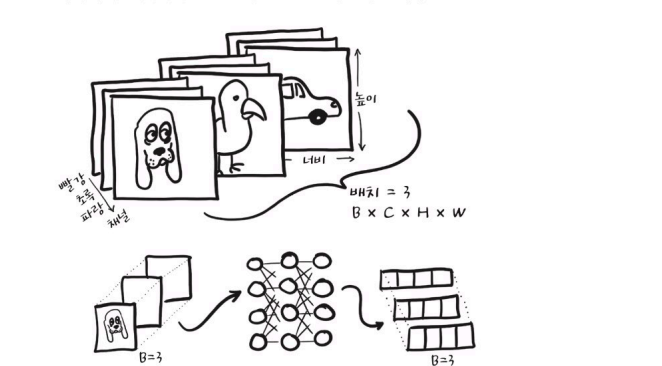

위 그림을 예시로 들면, 입력은 BxCxHxW(순서대로 배치, 채널, 높이, 너비)의 입력이다. 신경망을 지나면 BxNout(출력 피처의 수)차원의 텐서가 출력으로 나온다

In [12]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>params = ~부분을 Linear.params으로 바꿔주었따
    lr=1e-2)

In [13]:
linear_model.parameters()

<generator object Module.parameters at 0x000001C6BFE3DA80>

parameters()를 호출하면 서브모듈까지 재귀적으로 호출하며 만나는 모든 파라미터 리스트를 담은 리스트를 반환한다. 이 값을 그대로 생성자에 전달할 수 있다

In [14]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.6714]], requires_grad=True),
 Parameter containing:
 tensor([-0.6376], requires_grad=True)]

이제 training_loop을 바꿔주자. 옵티마이저에는 텐서 리스트가 전달되고, 텐서는 Paramters를 가지며 경사 하강으로 최적화 되야 하므로 requires_grad = True가 된다. training_loss.backword()가 호출되면 옵티마이저에 전달된 파라미터인 grad가 그래프의 말단 노드들에 누적된다

In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>개별 패러미터 대신 모델이 전달됬다. 
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


우리가 직접 만들었던 손실 함수인 loss_fn은 평균제곱오차 함수로, nn.MSELoss로 바꿔줄 수 있다.

In [16]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 145.0740, Validation loss 40.9949
Epoch 1000, Training loss 2.6136, Validation loss 9.2872
Epoch 2000, Training loss 2.1240, Validation loss 8.1743
Epoch 3000, Training loss 2.1155, Validation loss 8.0348

Parameter containing:
tensor([[5.3615]], requires_grad=True)
Parameter containing:
tensor([-16.7586], requires_grad=True)


In [17]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 168.1190, Validation loss 49.4802
Epoch 1000, Training loss 2.7121, Validation loss 9.4138
Epoch 2000, Training loss 2.1257, Validation loss 8.1896
Epoch 3000, Training loss 2.1155, Validation loss 8.0368

Parameter containing:
tensor([[5.3608]], requires_grad=True)
Parameter containing:
tensor([-16.7550], requires_grad=True)


앞에서 살펴본 선형 모델로는 복잡한 문제를 풀 수 없다, 비선형 근사를 통해 신경망을 깊게 쌓아야 하는데, 여기서 활성화 함수가 사용된다. 신경망 모듈을 블록으로 나타내야 하는데, 이를 아래와 같은 방법으로 나타내기도 한다.

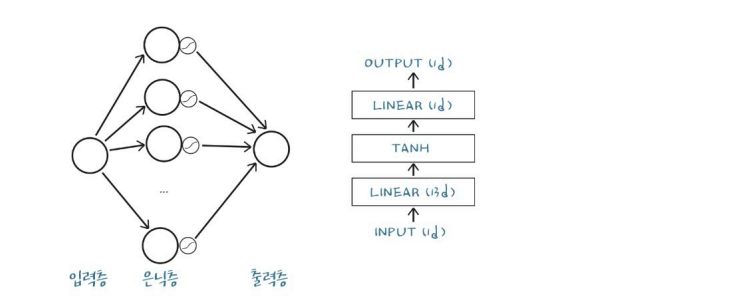

nn은 nn.Sequential 컨테이너를 통해 모듈을 간단하게 결합시켜준다. 아래는 하나의 은닉층을 가지고, 활성화 함수를 하이퍼볼릭 탄젠트 함수를 사용한 모델이다

In [18]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

파라미터를 살펴보기 위해 차원 정보를 출력해 보는 것이 좋다

In [19]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

named.parameters()는 가중치인지 편향인지 나타내준다. 

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Sequential은 인자에서 모듈이 나타낸 순서를 따르는데, OrderedDict로 인자를 받아 각 모듈의 이름을 정해서 전달해도 된다

In [21]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [22]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


이름을 붙이면 서브모듈을 더 쉽게 설명할 수 있고, 서브모듈을 속성처럼 사용해 Parameter에 접근할 수도 있다

In [23]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1911], requires_grad=True)

In [24]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>안정성을 위해 학습률을 줄여준 모습

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(), #loss_fn대신 nn.MSELoss 사용
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 208.9936, Validation loss 76.4306
Epoch 1000, Training loss 4.6459, Validation loss 9.2446
Epoch 2000, Training loss 3.6618, Validation loss 1.5318
Epoch 3000, Training loss 2.3550, Validation loss 1.9465
Epoch 4000, Training loss 1.8670, Validation loss 2.5852
Epoch 5000, Training loss 1.6924, Validation loss 3.2473
output tensor([[ 8.3170],
        [13.0045]], grad_fn=<AddmmBackward0>)
answer tensor([[ 6.],
        [11.]])
hidden tensor([[ 4.4512],
        [ 0.0543],
        [-0.1179],
        [-1.0453],
        [ 0.9592],
        [-5.7689],
        [-6.0122],
        [ 6.2991]])


신경망이 측정값을 과도하게 따라가는 과적합 성향을 보인다. 측정값이 얼마 되지 않기 때문에 필요한 양보다 많은 패러미터를 가지고 있는 셈이다. 비선형 근사를 통해 직선이 아닌 곡선인 그래프가 완성된 것을 볼 수 있다.

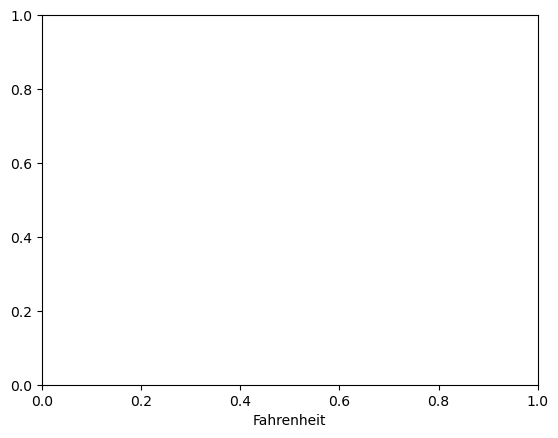

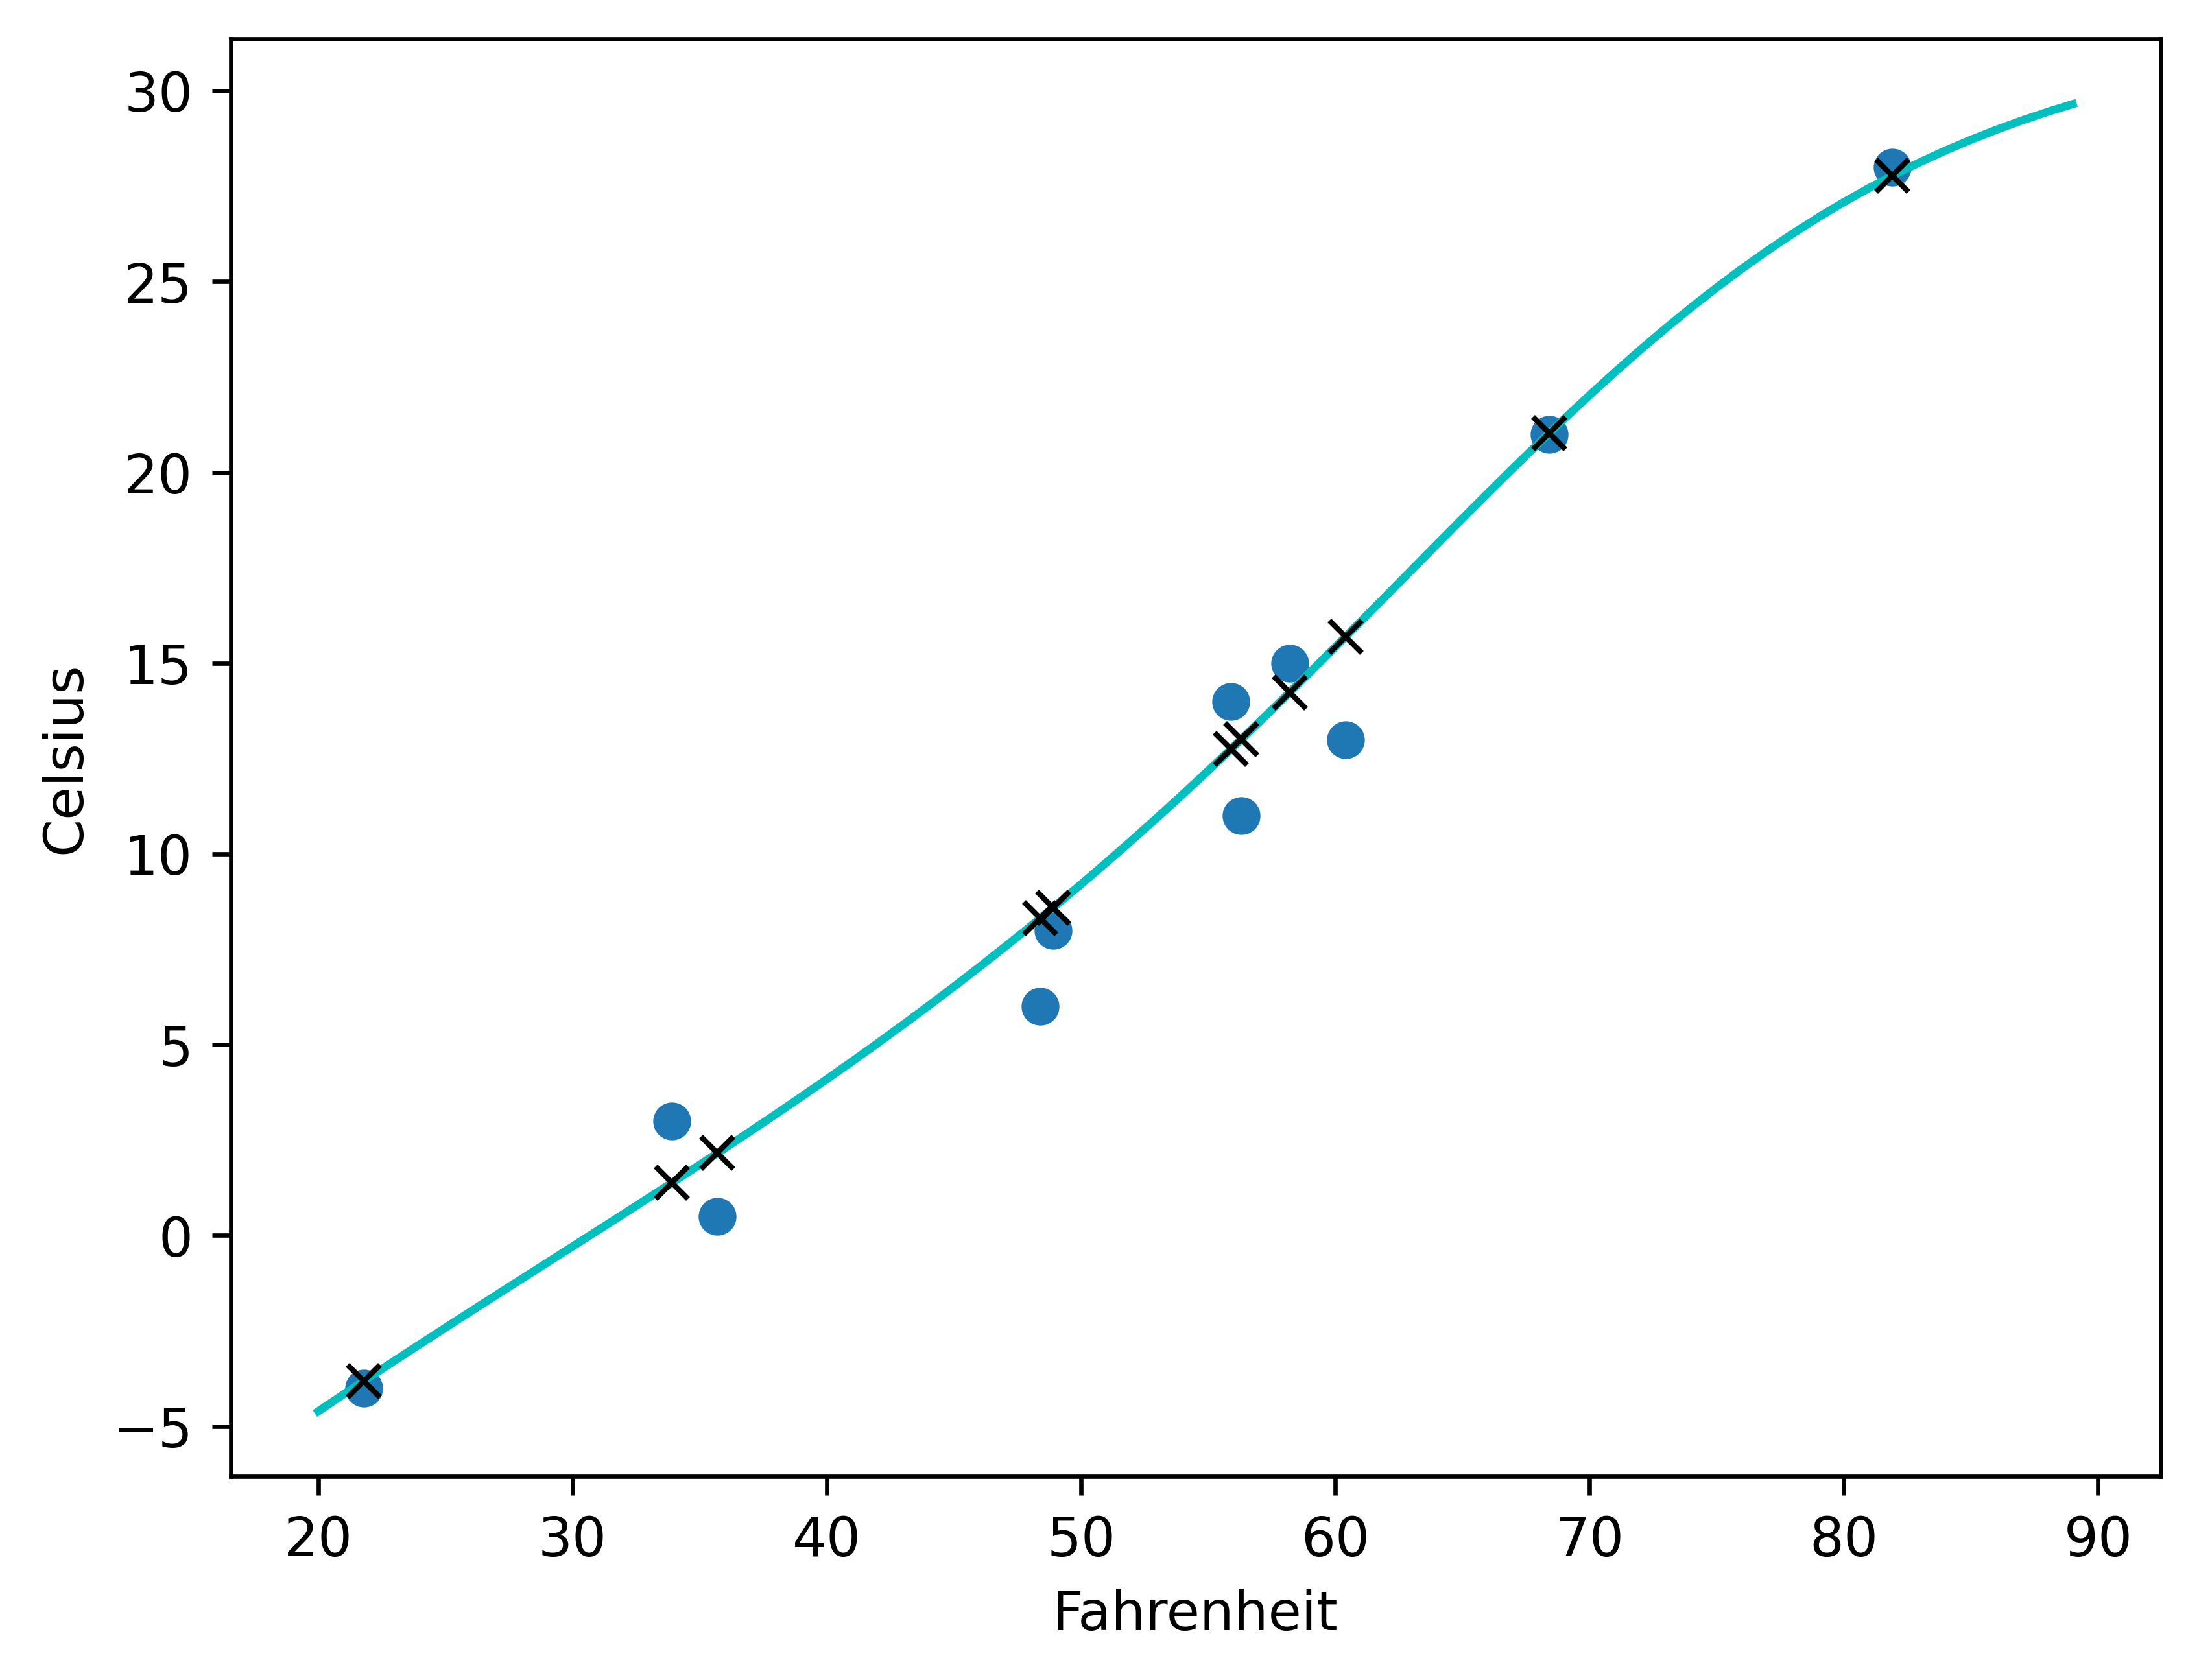

In [25]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

plt.xlabel("Fahrenheit")
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


## 연습 문제
1. 간단한 신경망 모델에서 여러 은닉층 뉴런과 학습률로 실험해보라\
a. 어떤 값을 바꿀 때 모델의 출력이 더욱 선형이 되었나?\
학습률을 올릴수록 손실이 변하는 폭이 줄고, 선형적으로 변한다\
b. 확실하게 과적합하는 모델을 만들 수 있는가?\
파라미터 개수를 늘릴수록 더욱 과적하는 모델이 된다. 뉴런의 개수를 늘리고 신경망을 깊게 쌓으면 확실하게 과적합하는 모델이 나온다.

Epoch 1, Training loss 221.2660, Validation loss 86.5484
Epoch 1000, Training loss 95.0247, Validation loss 7.1267
Epoch 2000, Training loss 75.6421, Validation loss 8.4842
Epoch 3000, Training loss 70.7552, Validation loss 13.0101
Epoch 4000, Training loss 67.4481, Validation loss 14.8348
Epoch 5000, Training loss 64.2778, Validation loss 15.2971


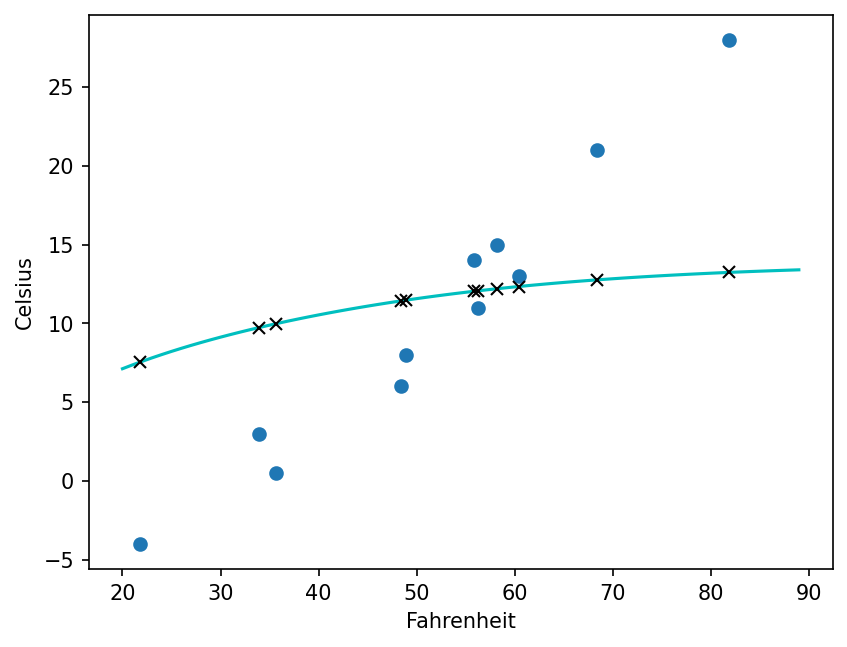

In [43]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 60)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(60, 1)),
    ('hidden_linear', nn.Linear(1, 60)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(60, 1)),
    ('hidden_linear', nn.Linear(1, 60)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(60, 1))
]))
optimizer = optim.SGD(seq_model.parameters(), lr = 1e-5)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val
)
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [45]:
import csv
import numpy as np
path = "data/p1ch4/tabular-wine/winequality-white.csv"
wine_np = np.loadtxt(path, dtype=np.float32, delimiter=";", skiprows=1)
ipt_data = torch.from_numpy(wine_np)
ipt_data

tensor([[ 7.0000,  0.2700,  ...,  8.8000,  6.0000],
        [ 6.3000,  0.3000,  ...,  9.5000,  6.0000],
        ...,
        [ 5.5000,  0.2900,  ..., 12.8000,  7.0000],
        [ 6.0000,  0.2100,  ..., 11.8000,  6.0000]])

In [46]:
ipt_data.shape

torch.Size([4898, 12])

In [51]:
target = ipt_data[:, -1]
target

tensor([6., 6.,  ..., 7., 6.])

In [50]:
n_sample = ipt_data.shape[0]-1
n_val = int(0.2*n_sample)

shuffle = torch.randperm(ipt_data.shape[0]-1)
train_indices = shuffle[:-n_val]
val_indices = shuffle[-n_val:]

In [ ]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices